In [1]:
!pip install pmdarima

### Importation des bibliothèques nécessaires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

### Importation du dataset AIRBUS SE à l'aide de Yahoo Finance

In [3]:
# AIRBUS AIR.PA
ticker = yf.Ticker("AIR.PA")
df = ticker.history(period="1y")
df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-24 00:00:00+01:00,153.720001,154.699997,153.660004,153.699997,187550,0.0,0.0
2024-12-27 00:00:00+01:00,154.000000,155.300003,153.399994,155.300003,773490,0.0,0.0
2024-12-30 00:00:00+01:00,154.259995,155.740005,154.020004,154.380005,753659,0.0,0.0
2024-12-31 00:00:00+01:00,153.220001,154.979996,153.160004,154.779999,278864,0.0,0.0
2025-01-02 00:00:00+01:00,155.699997,160.500000,155.619995,160.139999,1636969,0.0,0.0
2025-01-03 00:00:00+01:00,159.300003,159.460007,158.039993,158.580002,1040083,0.0,0.0
2025-01-06 00:00:00+01:00,158.619995,159.639999,155.779999,159.639999,1345018,0.0,0.0
2025-01-07 00:00:00+01:00,159.619995,160.179993,157.259995,158.399994,1585470,0.0,0.0
2025-01-08 00:00:00+01:00,158.080002,159.759995,157.600006,158.580002,1077965,0.0,0.0


In [4]:
df.size

1799

In [5]:
airbus_stock = df[['Open', 'High', 'Low', 'Close', 'Volume']]

### Description de chaque colonne

In [6]:
airbus_stock.describe()

,Open,High,Low,Close,Volume
count,257.000000,257.000000,257.000000,257.000000,2.570000e+02
mean,146.332411,147.566705,145.004821,146.330998,1.061152e+06
std,11.573246,11.558323,11.608979,11.603146,6.044637e+05
min,126.059998,126.919998,124.720001,126.339996,1.875500e+05
25%,136.000000,137.279999,134.720001,135.960007,7.458230e+05
50%,146.518905,147.740005,145.604521,146.757431,9.682950e+05
75%,156.815574,157.740005,155.444000,156.660004,1.306668e+06
max,170.173427,171.723882,169.755989,170.551102,8.026551e+06


In [7]:
airbus_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 257 entries, 2024-01-09 00:00:00+01:00 to 2025-01-09 00:00:00+01:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    257 non-null    float64
 1   High    257 non-null    float64
 2   Low     257 non-null    float64
 3   Close   257 non-null    float64
 4   Volume  257 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB


### Visualisation des données

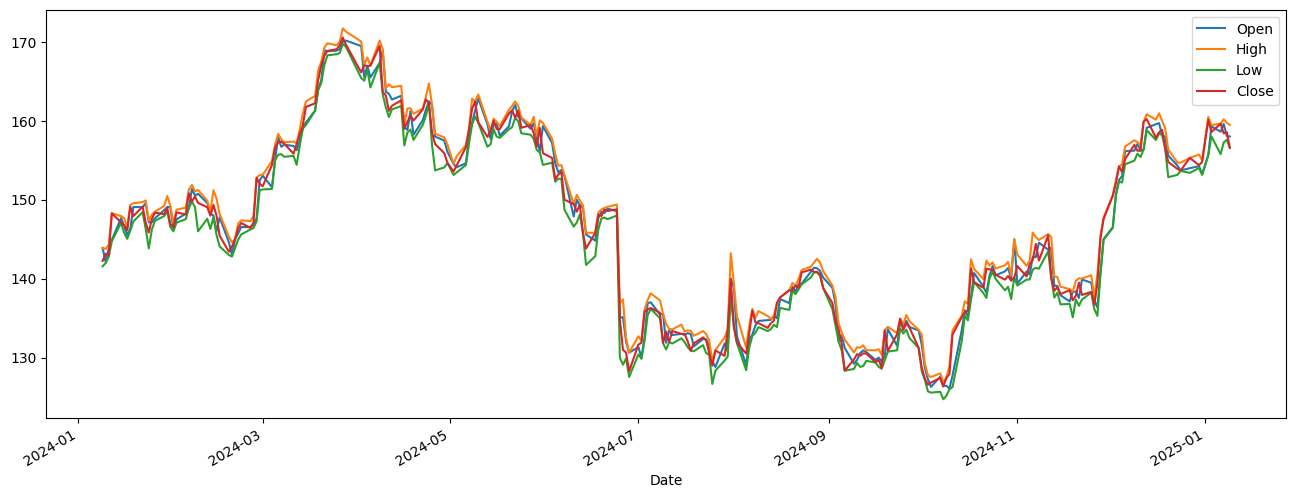

In [8]:
airbus_stock[['Open', 'High', 'Low', 'Close']].plot(figsize=(16, 6))
plt.show()

Dans ce code, nous allons visualiser les moyennes mobiles (Moving Averages) des données boursières pour mieux comprendre les tendances sur différentes périodes. Les moyennes mobiles sur 10, 20 et 40 jours seront calculées pour les colonnes `Open`, `High`, `Close` et `Volume`. Ces courbes permettront de lisser les variations des données brutes et de mettre en évidence les tendances sous-jacentes à court, moyen et long terme. Chaque graphique affichera les données originales ainsi que leurs moyennes mobiles correspondantes, facilitant ainsi l'analyse visuelle.

<ipython-input-9-85ef3e0affd7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbus_stock[column_name] = airbus_stock[column].rolling(ma).mean()


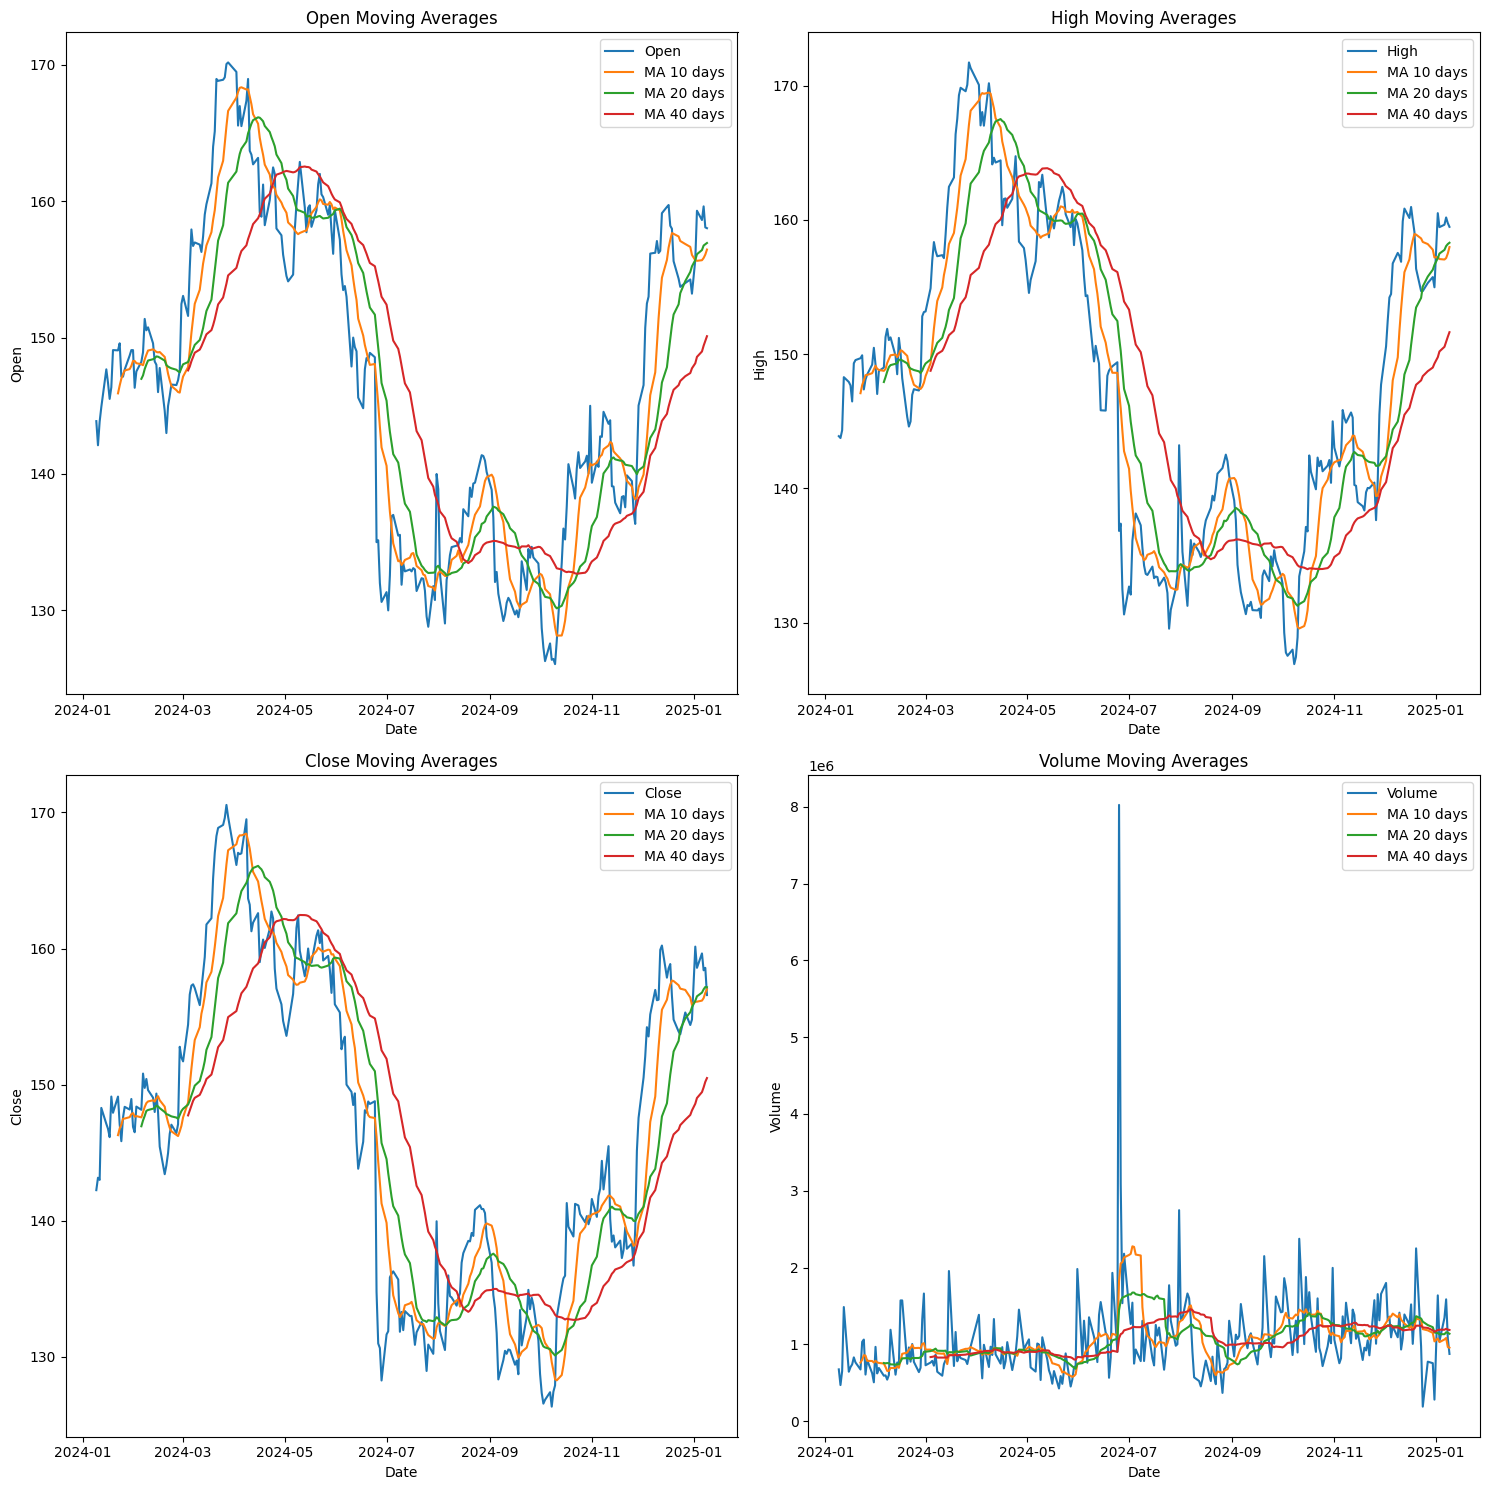

In [9]:
days = [10, 20, 40]
columns = ['Open', 'High', 'Close', 'Volume']

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)
axes = axes.flatten()

for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(airbus_stock.index, airbus_stock[column], label=column)

    for ma in days:
        column_name = f"{column} MA for {ma} days"
        airbus_stock[column_name] = airbus_stock[column].rolling(ma).mean()
        ax.plot(airbus_stock.index, airbus_stock[column_name], label=f"MA {ma} days")

    ax.set_title(f"{column} Moving Averages")
    ax.set_xlabel("Date")
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

## La prédiction des données

Maintenant, on va utiliser un modèle classique pour les séries temporelles, c'est ARIMA

In [10]:
close_data = airbus_stock['Close']

train_size = int(len(close_data) * 0.8)
train_data = close_data[:train_size]
test_data = close_data[train_size:]

auto_model = pm.auto_arima(
    train_data,
    start_p=1, max_p=5,
    start_q=1, max_q=5,
    d=None,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=896.254, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=893.151, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=894.437, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=894.487, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=891.152, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.901 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


L'adaptation du modèle

In [11]:
print(auto_model.summary())


optimal_order = auto_model.order
final_model = ARIMA(train_data, order=optimal_order)
fitted_model = final_model.fit()


print(fitted_model.summary())


forecast = fitted_model.forecast(steps=len(test_data))
mse = mean_squared_error(test_data, forecast)

print(f"Mean Squared Error: {mse}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -444.576
Date:                Thu, 09 Jan 2025   AIC                            891.152
Time:                        23:41:29   BIC                            894.470
Sample:                             0   HQIC                           892.495
                                - 205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.5755      0.196     23.319      0.000       4.191       4.960
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):               682.80
Prob(Q):                              0.39   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

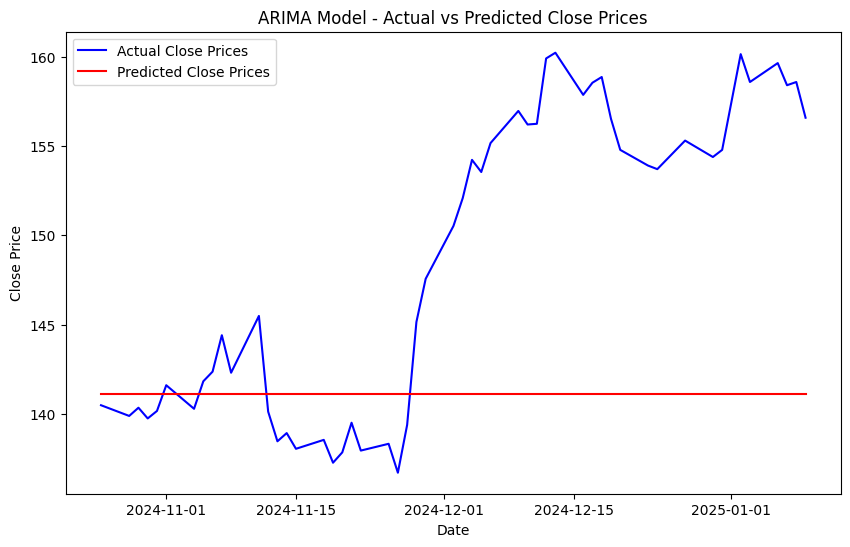

Mean Squared Error (MSE): 123.2728164377488


In [12]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label="Actual Close Prices", color="blue")
plt.plot(test_data.index, forecast, label="Predicted Close Prices", color="red")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("ARIMA Model - Actual vs Predicted Close Prices")
plt.legend()
plt.show()

mse = mean_squared_error(test_data, forecast)
print(f"Mean Squared Error (MSE): {mse}")

Nous remarquons qu'ARIMA ne permet pas de donner de bons résultats car il est conçu pour les données stationnaires, ce qui n'est pas le cas ici.

## Prédiction avec l'apprentissage automatique (ML) moderne


### LSTM

Maintenant, on va utiliser LSTM pour faire la prévision.

In [13]:
ticker = yf.Ticker("AIR.PA")
df = ticker.history(period="5y")
df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-24 00:00:00+01:00,153.720001,154.699997,153.660004,153.699997,187550,0.0,0.0
2024-12-27 00:00:00+01:00,154.000000,155.300003,153.399994,155.300003,773490,0.0,0.0
2024-12-30 00:00:00+01:00,154.259995,155.740005,154.020004,154.380005,753659,0.0,0.0
2024-12-31 00:00:00+01:00,153.220001,154.979996,153.160004,154.779999,278864,0.0,0.0
2025-01-02 00:00:00+01:00,155.699997,160.500000,155.619995,160.139999,1636969,0.0,0.0
2025-01-03 00:00:00+01:00,159.300003,159.460007,158.039993,158.580002,1040083,0.0,0.0
2025-01-06 00:00:00+01:00,158.619995,159.639999,155.779999,159.639999,1345018,0.0,0.0
2025-01-07 00:00:00+01:00,159.619995,160.179993,157.259995,158.399994,1585470,0.0,0.0
2025-01-08 00:00:00+01:00,158.080002,159.759995,157.600006,158.580002,1077965,0.0,0.0


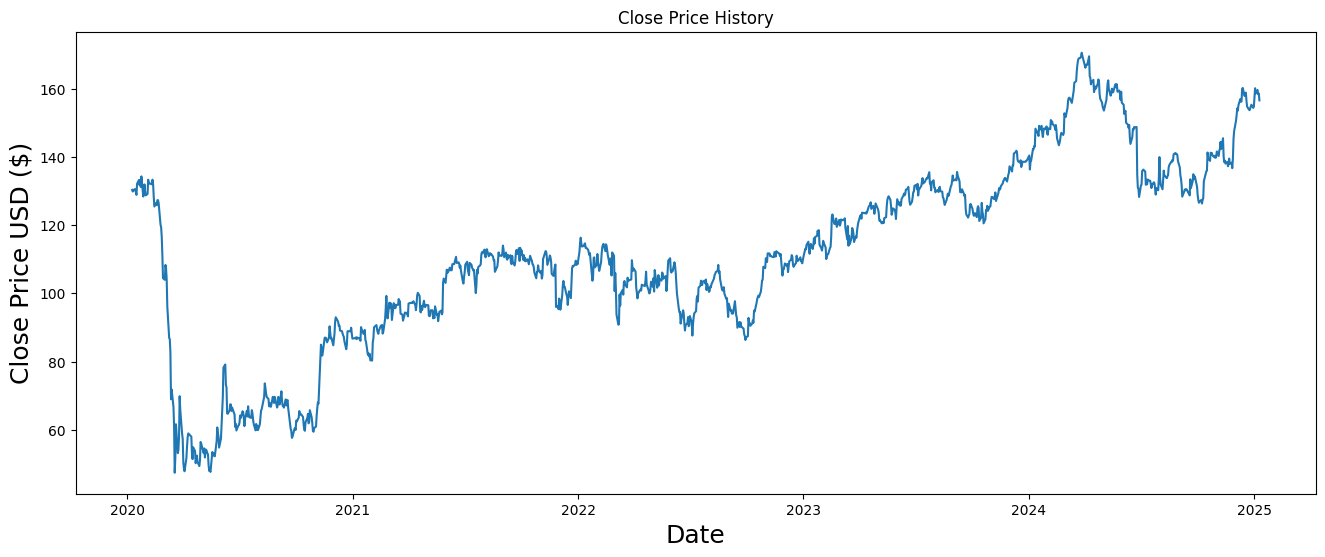

In [14]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [15]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(len(dataset) * 0.95)

training_data_len

1219

On va effectuer un mise à l'échelle des données (scaling):

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.67351386],
       [0.66959131],
       [0.67508273],
       ...,
       [0.90133092],
       [0.90279261],
       [0.88655227]])

On va utiliser 60 séquences pour prédire la suivante.



In [17]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.67351386, 0.66959131, 0.67508273, 0.67492587, 0.66833628,
       0.66158983, 0.68810516, 0.6968912 , 0.68512416, 0.69751889,
       0.68041717, 0.70552061, 0.65766728, 0.66817942, 0.68637918,
       0.670219  , 0.66033469, 0.66378628, 0.69767576, 0.68888972,
       0.68983102, 0.68810516, 0.68684989, 0.69767576, 0.68669303,
       0.65688285, 0.6338193 , 0.64260539, 0.63695716, 0.64903824,
       0.64888125, 0.6415071 , 0.59082975, 0.58424023, 0.56086271,
       0.51724572, 0.46311677, 0.45935133, 0.49465281, 0.48555281,
       0.46013583, 0.39565161, 0.32104778, 0.3181452 , 0.28739366,
       0.17489943, 0.19819846, 0.15638576, 0.10963087, 0.        ,
       0.03659591, 0.11543602, 0.04655881, 0.05424668, 0.08586116,
       0.18219508, 0.1498746 , 0.09307838, 0.08060515, 0.02459342])]
[0.009453006949991516]

[array([0.67351386, 0.66959131, 0.67508273, 0.67492587, 0.66833628,
       0.66158983, 0.68810516, 0.6968912 , 0.68512416, 0.69751889,
       0.68041717, 0.70552061, 0.6

In [18]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1159/1159 ━━━━━━━━━━━━━━━━━━━━ 69s 53ms/step - loss: 0.0085


La performance du modèle LSTM

```
# This is formatted as code
```



In [19]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean((predictions - y_test) ** 2)
mse

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


25.887462272517418

<ipython-input-20-bac245597b66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


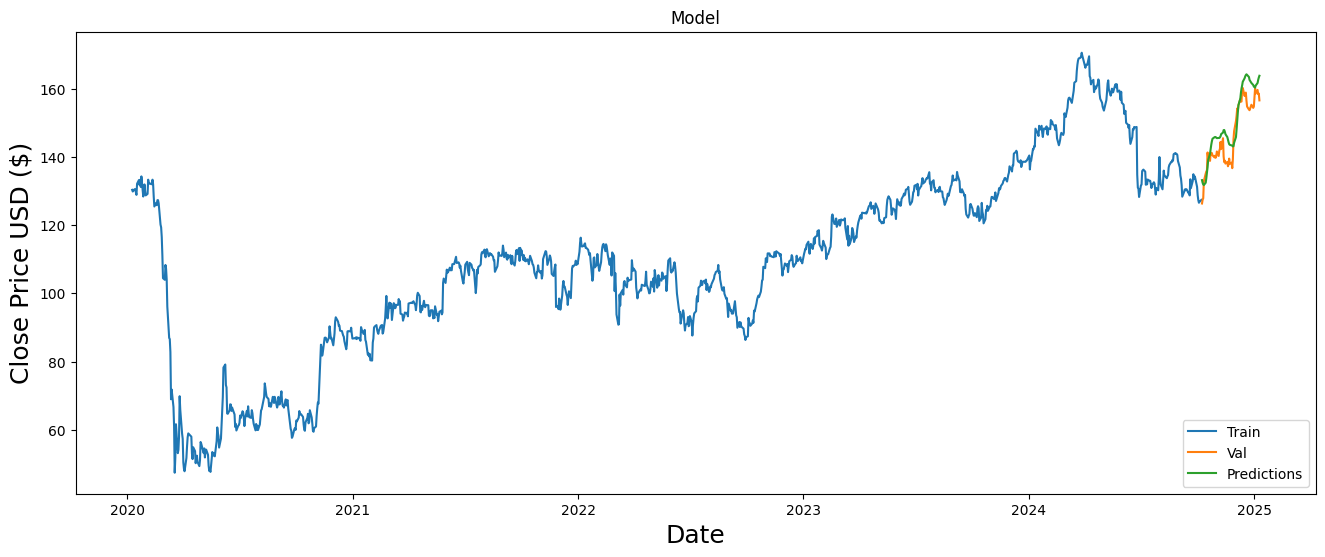

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

On remarque que LSTM a bien réalisé la prévision.

In [21]:
data = airbus_stock[['Close']]

data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)

data = data.dropna()

X = data[['Lag1', 'Lag2', 'Lag3']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


<ipython-input-21-a090c8720adc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag1'] = data['Close'].shift(1)
<ipython-input-21-a090c8720adc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag2'] = data['Close'].shift(2)
<ipython-input-21-a090c8720adc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

### XGBoost

Maintenant, on va utiliser XGBoost pour faire la prévision.

In [22]:
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

params = {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100
}

model = xgb.train(params, train_dmatrix, num_boost_round=100)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


La performance du modèle

In [23]:
predictions = model.predict(test_dmatrix)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})


Mean Squared Error: 5.451464368331739


On remarque que XGBoost a bien réalisé la prévision.

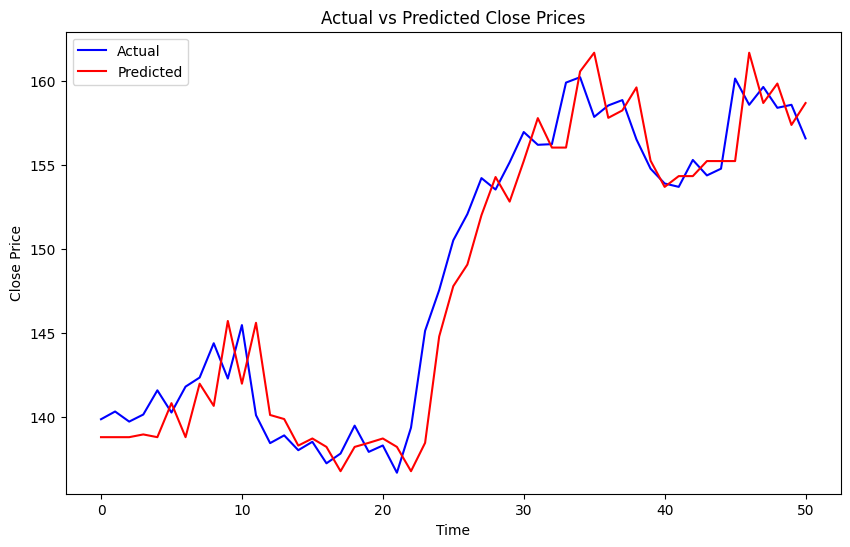

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()


## Conclusion

On peut conclure que les modèles modernes de ML donnent de bons résultats, contrairement aux modèles classiques comme ARIMA et SARIMA, qui ont beaucoup de conditions, telles que la stationnarité pour ARIMA et la saisonnalité pour SARIMA. En revanche, LSTM et XGBoost peuvent bien performer avec ce type de données.